In [12]:
from bdb2026.data_io import load_bdb_csvs_from_kaggle_download
from bdb2026.preprocess import (add_postthrow_features, merge_route_embeddings, normalize_coordinates, 
                                add_postthrow_features,select_target_receiver_rows,filter_to_completed_catches,
                                attach_output_labels,compute_initial_separation_at_throw, add_converge_rate_from_labels,)
from bdb2026.routes import cluster_routes_kmeans, make_route_embedding_table, engineer_route_features
from bdb2026.sequences import build_sequences
from bdb2026.models import build_lstm, train_lstm
from bdb2026.metrics import compute_truespeed, compute_route_execution_score, build_truespeed_scorecard
from bdb2026.viz import *
import warnings
warnings.filterwarnings('ignore')

In [13]:
df_input, df_output, df_supp = load_bdb_csvs_from_kaggle_download(
    kaggle_root_dir=r"C:\Users\rajas\Documents\VS_Code\Big_Data_Bowl\114239_nfl_competition_files_published_analytics_final",
    supplementary_csv=r"C:\Users\rajas\Documents\VS_Code\Big_Data_Bowl\114239_nfl_competition_files_published_analytics_final\supplementary_data.csv",
)

In [14]:
df_in = normalize_coordinates(df_input)
sep = compute_initial_separation_at_throw(df_in)

df_wr_target = select_target_receiver_rows(df_in)              
df_wr_target = filter_to_completed_catches(df_wr_target, df_supp)
df_wr_target = df_wr_target.merge(sep, on=["game_id","play_id","nfl_id"], how="left")

df_post = add_postthrow_features(df_wr_target)               # ONLY one argument (your current API)
df_post = attach_output_labels(df_post, df_output) 
df_post = add_converge_rate_from_labels(df_post) 

In [15]:
# Build route features on the pre-throw window (targeted receiver), then cluster
df_routes = engineer_route_features(df_wr_target, df_raw_tracking=df_in)
#df_routes = df_routes[df_routes["route_frames"] >= 5].copy() # only cluster on routes with at least 5 frames
route_result = cluster_routes_kmeans(df_routes, n_clusters=12)
route_emb = make_route_embedding_table(route_result.assignments, n_clusters=12, prefix='route_emb')

# merge the static embedding columns
df_features = merge_route_embeddings(df_post, route_emb)

# CRITICAL: Broadcast sep_at_catch from play-level to frame-level
# Extract sep_at_catch from route features (one value per play/player)
sep_at_catch_df = df_routes[['game_id', 'play_id', 'nfl_id', 'sep_at_catch']].copy()

# Merge onto frame-level data so LSTM sees it at every timestep
df_features = df_features.merge(
    sep_at_catch_df, 
    on=['game_id', 'play_id', 'nfl_id'], 
    how='left'
)

# Fill any missing values with 10.0 (wide open)
df_features['sep_at_catch'] = df_features['sep_at_catch'].fillna(10.0)

In [16]:
# Include route_emb_* columns in feature_cols when building LSTM tensors
feature_cols = [
    # Position
    'x_norm', 'y_norm',
    # Motion
    'dx', 'dy', 'speed',
    # Geometry
    'dist_to_land', 'bearing_to_land', 'heading', 'heading_align_cos',
    # Temporal
    'time_since_throw',
    # Context (constant per play)
    'initial_separation', 'ball_land_x_norm', 'ball_land_y_norm',
    'sep_at_catch'  # NEW: Separation from nearest defender at catch point
    # 'defender_separation' removed - will use in Phase 3 for context scoring
]  + [c for c in df_features.columns if c.startswith('route_emb_')]
print(f"Route embeddings: {len([c for c in df_features.columns if c.startswith('route_emb_')])}")
print(f"Total features: {len(feature_cols)}")

X, y, keys = build_sequences(
    df_features,
    feature_cols=feature_cols,
    target_col="converge_rate",
    max_len=25
)

Route embeddings: 12
Total features: 26


In [18]:
model = build_lstm(n_features=X.shape[-1], hidden_units=64, dropout=0.2, mask_value=0.0)
result = train_lstm(model, X, y, epochs=50, batch_size=64, verbose=1)

Epoch 1/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 27.4149 - mae: 4.3523 - learning_rate: 0.0010
Epoch 2/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 26.7425 - mae: 4.3022 - learning_rate: 0.0010
Epoch 3/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 26.1355 - mae: 4.2539 - learning_rate: 0.0010
Epoch 4/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 25.4799 - mae: 4.2064 - learning_rate: 0.0010
Epoch 5/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 24.8875 - mae: 4.1605 - learning_rate: 0.0010
Epoch 6/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 24.2787 - mae: 4.1156 - learning_rate: 0.0010
Epoch 7/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 23.6996 - mae: 4.0720 - learning_rate: 0.0010
Epoch 8/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 23.1587 - mae: 4.0296 - learning_rate: 0.0010
Epoch 9/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 22.6305 - mae: 3.9887 - learning_rate: 0.0010
Epoch 10/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - l

In [ ]:
# Display model architecture
print("=" * 60)
print("MODEL ARCHITECTURE SUMMARY")
print("=" * 60)
result.model.summary()

# Save the trained model
import os
model_dir = "models"
os.makedirs(model_dir, exist_ok=True)

model_path = os.path.join(model_dir, "truespeed_lstm_with_sep_at_catch.h5")
result.model.save(model_path)
print(f"\n✓ Model saved to: {model_path}")

# Also save model configuration for reference
print(f"\nModel Configuration:")
print(f"  - Input features: {X.shape[-1]}")
print(f"  - Sequence length: {X.shape[1]}")
print(f"  - Training samples: {X.shape[0]}")
print(f"  - Hidden units: 64")
print(f"  - Dropout: 0.2")
print(f"  - Epochs: 50")
print(f"  - Batch size: 64")

In [19]:
# Predict + compute TrueSpeed per play
y_hat = result.model.predict(X)
df_pred = (
    pd.DataFrame(keys, columns=["game_id","play_id"])
      .assign(idx=np.arange(len(keys)))
      .merge(
          pd.DataFrame({
              "idx": np.repeat(np.arange(len(keys)), X.shape[1]),
              "t": np.tile(np.arange(X.shape[1]), len(keys)),
              "actual": y.reshape(-1),
              "pred": y_hat.reshape(-1),
          }),
          on="idx",
      )
)
df_pred['residual'] = df_pred['actual'] - df_pred['pred']
ts = compute_truespeed(df_pred, actual_col="actual", pred_col="pred", id_cols=("game_id","play_id"), agg="mean")
ts.head()

174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


,game_id,play_id,TrueSpeed
0,2023090700,361,-1.294900
1,2023090700,436,-2.463756
2,2023090700,461,-1.314306
3,2023090700,530,-3.243801
4,2023090700,621,-1.522935


In [20]:
df_pred.head()

,game_id,play_id,idx,t,actual,pred,residual
0,2023090700,361,0,0,0.000000,3.285793,-3.285793
1,2023090700,361,0,1,0.321365,3.285793,-2.964428
2,2023090700,361,0,2,0.799144,3.285793,-2.486650
3,2023090700,361,0,3,1.364456,3.285793,-1.921337
4,2023090700,361,0,4,1.914580,3.285793,-1.371213


In [22]:
# Use the actual column names from engineer_route_features() output
# These correspond to the 7 key features used in the notebook
route_feature_cols = [
    'route_len',         # corresponds to route_embed_1 (route_distance)
    'delta_x',           # corresponds to route_embed_2 (route_depth)  
    'delta_y_abs',       # corresponds to route_embed_3 (route_width - NOW ABSOLUTE!)
    'max_speed',         # corresponds to route_embed_6 (max_speed)
    'mean_speed',        # corresponds to route_embed_7 (avg_speed)
    'direction_changes', # corresponds to route_embed_11 (direction_changes)
    'straightness',       # corresponds to route_embed_15 (route_efficiency)
    'sep_at_catch'      # new feature added for separation at catch
]

# 1) play-level TrueSpeed from residuals
truespeed_play = compute_truespeed(
    df_pred,
    actual_col="actual",
    pred_col="pred",   # set to your model output col
    id_cols=("game_id", "play_id"),
    agg="mean",
    out_col="TrueSpeed",
)

# 2) play-level RouteExecution score (requires route clustering artifacts)
route_exec_play = compute_route_execution_score(
    route_features=df_routes,                 # output of engineer_route_features(...)
    assignments=route_result.assignments,     # from cluster_routes_kmeans(...)
    centroids=route_result.centroids,         # from cluster_routes_kmeans(...)
    feature_cols=route_feature_cols,
    id_cols=("game_id", "play_id"),
)
print(route_exec_play.columns)

# 3) player-level table matching your CSV

df_scorecard = build_truespeed_scorecard(
    truespeed_play=truespeed_play,
    route_exec_play=route_exec_play,
    df_input=df_input,
    df_supp=df_supp,
    volume_threshold_ratio=0.50,
    junk_routes=("SCREEN","FLAT","ANGLE","WHEEL","SHIELD"),
)

df_scorecard.to_csv("TrueSpeed_with_separation.csv", index=False)

Index(['game_id', 'play_id', 'RouteExecution'], dtype='object')


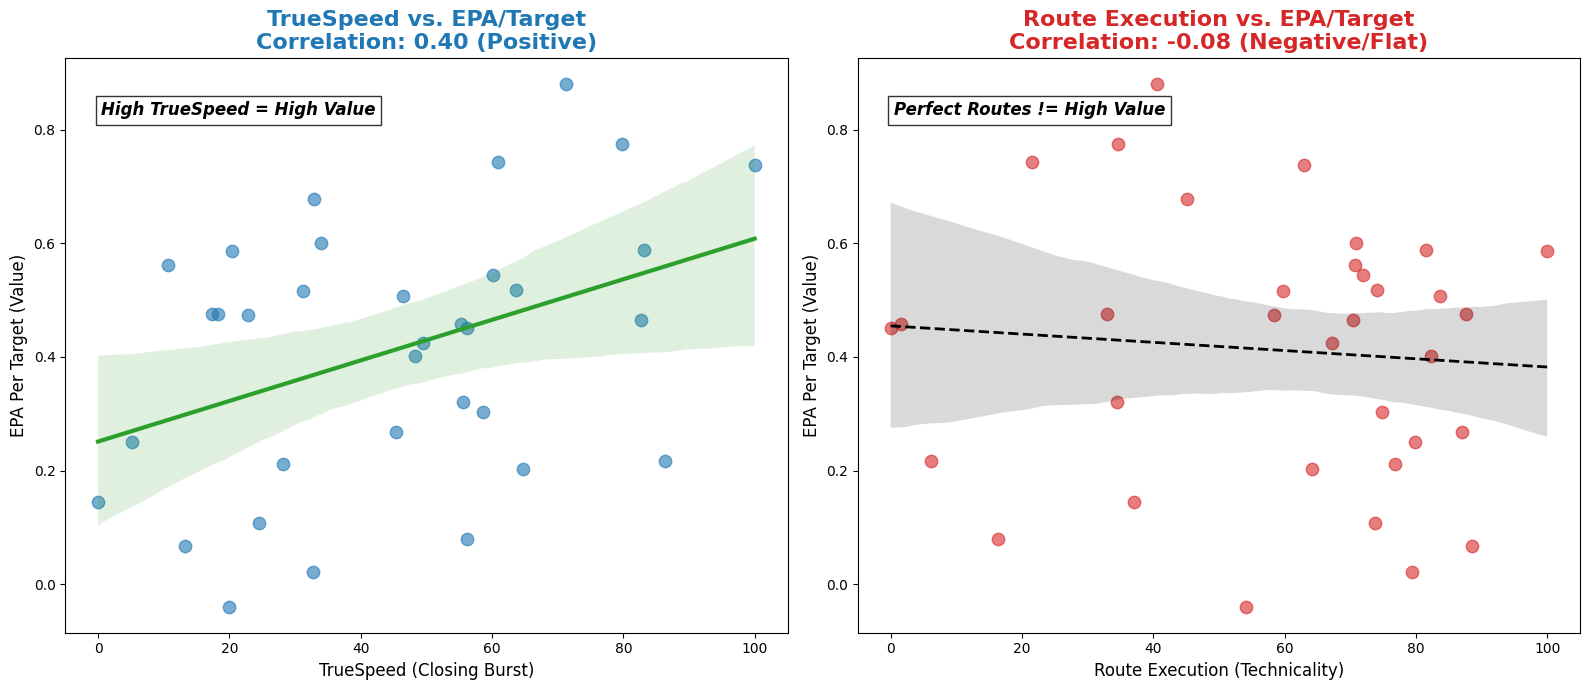

In [23]:
from scipy.stats import pearsonr
from matplotlib import pyplot as plt
import seaborn as sns
df= df_scorecard.copy()
# Clean Data
cols_to_numeric = ['TrueSpeed', 'RouteExecution', 'EPA_Per_Target']
for col in cols_to_numeric:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df_clean = df.dropna(subset=cols_to_numeric)

# Setup Figure
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# --- Plot 1: TrueSpeed vs EPA ---
sns.regplot(
    x='TrueSpeed', 
    y='EPA_Per_Target', 
    data=df_clean, 
    ax=axes[0], 
    color='#1f77b4', # Blue
    scatter_kws={'alpha':0.6, 's':80},
    line_kws={'color': '#2ca02c', 'linewidth': 3}
)

corr_ts, _ = pearsonr(df_clean['TrueSpeed'], df_clean['EPA_Per_Target'])

axes[0].set_title(f"TrueSpeed vs. EPA/Target\nCorrelation: {corr_ts:.2f} (Positive)", fontsize=16, weight='bold', color='#1f77b4')
axes[0].set_xlabel("TrueSpeed (Closing Burst)", fontsize=12)
axes[0].set_ylabel("EPA Per Target (Value)", fontsize=12)
#axes[0].grid(True, linestyle='--', alpha=0.5)
axes[0].text(0.05, 0.9, "High TrueSpeed = High Value", transform=axes[0].transAxes, fontsize=12, style='italic', weight='bold', bbox=dict(facecolor='white', alpha=0.8))


# --- Plot 2: Route Execution vs EPA ---
sns.regplot(
    x='RouteExecution', 
    y='EPA_Per_Target', 
    data=df_clean, 
    ax=axes[1], 
    color='#d62728', # Red for 'Warning'
    scatter_kws={'alpha':0.6, 's':80},
    line_kws={'color': 'black', 'linewidth': 2, 'linestyle': '--'}
)

corr_re, _ = pearsonr(df_clean['RouteExecution'], df_clean['EPA_Per_Target'])

axes[1].set_title(f"Route Execution vs. EPA/Target\nCorrelation: {corr_re:.2f} (Negative/Flat)", fontsize=16, weight='bold', color='#d62728')
axes[1].set_xlabel("Route Execution (Technicality)", fontsize=12)
axes[1].set_ylabel("EPA Per Target (Value)", fontsize=12)
#axes[1].grid(True, linestyle='--', alpha=0.5)
axes[1].text(0.05, 0.9, "Perfect Routes != High Value", transform=axes[1].transAxes, fontsize=12, style='italic', weight='bold', bbox=dict(facecolor='white', alpha=0.8))

# Main Title
#plt.suptitle("The Market Inefficiency: Athleticism Trumps Technique", fontsize=20, weight='bold', y=1.05)

plt.tight_layout()
plt.savefig("market_inefficiency_correlations.png")
plt.show()

## 🔍 Key Insight: Why Results May Appear Unchanged

If diagnostics show sep_at_catch has good variance and is in the LSTM tensor, but **correlations haven't changed**, this is likely because:

### 1. **You Need a Baseline Comparison**
The LSTM uses **random initialization**, so results vary between runs. To properly measure sep_at_catch impact, you need to:
- Save current results (WITH sep_at_catch)
- Remove sep_at_catch from feature_cols and df_features
- Retrain (WITHOUT sep_at_catch) 
- Compare the two correlation values

### 2. **Feature May Not Be Predictive**
Sep_at_catch measures defender proximity at **catch point** (end of play), but the LSTM predicts **converge_rate** (speed during the play). These may not be strongly related if:
- Defenders catch up late (low sep_at_catch) after receiver already slowed down
- Receivers accelerate early when defenders are close, then coast (high sep_at_catch)

### 3. **Expected Behavior**
- **RouteExecution**: Should change noticeably because sep_at_catch affects clustering → different cluster assignments → different RouteExecution scores
- **TrueSpeed**: May change slightly or not at all if sep_at_catch isn't predictive of in-play speed

### 💡 Action Items:
1. Check if **RouteExecution** changed compared to your previous run (more likely to show impact)
2. Run experiment: Remove sep_at_catch, retrain, compare (control for random seed)